# OLS regression in python

This is a notebook to show how to run a simple OLS regression in python. I am going to assume that users are already familar with OLS regressions and with a bit of python. This notebook is aimed at people who want to see how to do a regression in python.

## The task and data

We have collected (faked) data from 500 participants asking them to rate their happiness on our brand new questionnaire! The questionnaire returns a continous variable, as well as asking people what their gender is (dummy variable), age and years in education.

We want to see if gender, age or years in education is related at all to happiness

## Code time
First import the necessary libaries. We are going to use statsmodels.formula.api OLS regression, this is to keep things simple but if you don't want to use the formula option then use statsmodel.api ols. We are also going to use pandas/numpy for data manipulation, seaborn for plotting as well as scipy and statsmodels for general statistical functions.


In [2]:
from statsmodels.formula.api import ols
from statsmodels.stats.api import  het_breuschpagan
from statsmodels.compat import lzip
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('dark')

First lets read in the data and explore it by checking the descriptive stats and if there are any null values

In [3]:
df = pd.read_csv('data/questionnaire_data.csv')

In [6]:
df.isnull().any()

age                   False
years_in_education    False
gender                False
questionnaire         False
dtype: bool

In [7]:
df.describe()

,age,years_in_education,gender,questionnaire
count,500.000000,500.00000,500.000000,500.000000
mean,23.498000,15.10400,0.494000,3.549960
std,3.525742,2.57963,0.500465,0.811965
min,18.000000,11.00000,0.000000,1.980000
25%,20.000000,13.00000,0.000000,2.990000
50%,23.000000,15.00000,0.000000,3.480000
75%,27.000000,17.00000,1.000000,4.140000
max,29.000000,19.00000,1.000000,5.510000


Great, no null values.

Now lets Build our model. We are going to use one of the simplest linear regressions the OLS regression. We are interested in the relationship between age, years in education and gender to our questionnaire data. 

In [17]:
ols_regression_model = ols('questionnaire ~ age + years_in_education  + gender', data=df)

The syntax for ols formulas might look a bit weird but it luckly it is a fairly standard one used in lots of other packages and in the language R.

```~``` splits the fomula into dependent (left side) and independent (right) variables.

```+``` means that we are adding more covariates to the model

We then fit the model and print out the summary

In [21]:
fitted_model = ols_regression_model.fit()

In [22]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          questionnaire   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     9735.
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        11:30:43   Log-Likelihood:                 489.65
No. Observations:                 500   AIC:                            -969.3
Df Residuals:                     495   BIC:                            -948.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -3.4794      0.044    -78.373      0.000      -3.567      -3.392
age                    0.1493      0.002     94.644      0.000       0.146       0.152
years_in_education     0.2330      0.002    146.847      0.000       0.230       0.236
age:gender             0.0038      0.002      1.633      0.103      -0.001       0.008
gender                -0.0854      0.055     -1.541      0.124      -0.194       0.023
==============================================================================
Omnibus:                        0.333   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.846   Jarque-Bera (JB):                0.188
Skew:                          -0.015   Prob(JB):                        0.910
Kurtosis:                       3.090   Cond. No.                         481.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Great we can see that age and years in education are statstically significant predictors of the questionnaire data, and our model exaplins 99% of the variation!! (this is because of how the data was faked if you see this in RL then the model has huge problems with it)

But what about diagnostics? To calculate p-values etc we need the residuals to be normally distributed. We also need to test that there are is no multiconlinearity or heteroscedasticity (that the residual variance does not depend on the variables in x in the form) in our model.

Don't worry this is easy in python. First we can get the residuals from our fitted model easily and using scipy.stats.normaltest as well as plotting them we can test to see if they are normally distrubuted 

In [23]:
residuals = fitted_model.resid

In [26]:
scipy.stats.normaltest(residuals)

NormaltestResult(statistic=0.33331205824311627, pvalue=0.8464907294260392)

<Axes: ylabel='Density'>

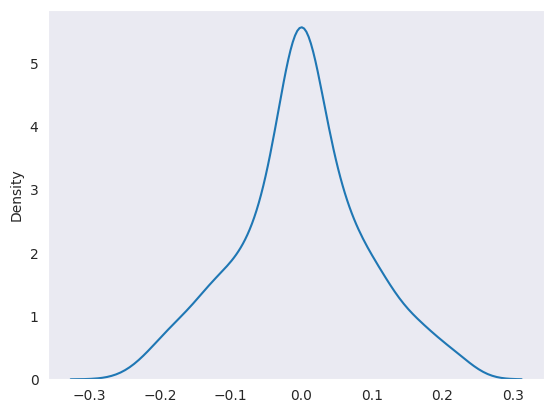

In [28]:
sns.kdeplot(x=residuals)

So the residuals are normally distributed. But how about Heteroscedasticity? We can use the Breusch-Pagan test to test for this. The null hypothesis for this is that Homoscedasticity is present. This can be found in statsmodels.stats.api. We need the residuals for this test and the values from the model. 

In [38]:
names = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = het_breuschpagan(residuals, df[['age' , 'years_in_education', 'gender']])
lzip(names, test)

[('Lagrange multiplier statistic', 161.37961128886135),
 ('p-value', 9.054462257805264e-36),
 ('f-value', 78.95337422518467),
 ('f p-value', 8.844782857366815e-42)]

There is a huge amount of Heteroscedasticity in the data, this is to be expected due to the way the data was faked. We can also test for multiconlinearity in the data using statmodels again

In [41]:
vif_data = pd.DataFrame()
vif_data["feature"] = df[['age' , 'years_in_education', 'gender']].columns
vif_data["VIF"] = [variance_inflation_factor(df[['age' , 'years_in_education', 'gender']].values, value)
                          for value in range(len(df[['age' , 'years_in_education', 'gender']].columns))]
  
print(vif_data)

              feature        VIF
0                 age  20.638637
1  years_in_education  20.514160
2              gender   1.977706


Again huge amount of problems due to the way the data was faked. In real life we would want to consider strategies such as robust regression or transforming the variables which is incredibly easy in python. In our case this is unlikely to work again due to how the data was faked but lets try.

First lets transform the data to log 10 using numpy

In [46]:
df_transformed = np.log10(df[['age' , 'years_in_education', 'questionnaire']])
df_transformed['gender'] = df['gender']

Then lets run a robust regression with the same tests we did before to see if this solves the problem. This time I am not going to use the formula, so I will need to explictly add the intercept

In [48]:
import statsmodels.api as sm

exogs = sm.add_constant(df_transformed[['age' , 'years_in_education', 'gender']])
rlm_model = sm.RLM(df_transformed['questionnaire'], exogs, M=sm.robust.norms.HuberT())
fitted_rlm_model = rlm_model.fit()
residulas_from_rlm = fitted_rlm_model.resid


In [49]:
names = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = het_breuschpagan(residulas_from_rlm, df_transformed[['age' , 'years_in_education', 'gender']])
lzip(names, test)

[('Lagrange multiplier statistic', 497.15347464272986),
 ('p-value', 1.107884922079395e-108),
 ('f-value', 28934.138512224068),
 ('f p-value', 0.0)]

In [51]:
vif_data = pd.DataFrame()
vif_data["feature"] = df_transformed[['age' , 'years_in_education', 'gender']].columns
vif_data["VIF"] = [variance_inflation_factor(df_transformed[['age' , 'years_in_education', 'gender']].values, value)
                          for value in range(len(df_transformed[['age' , 'years_in_education', 'gender']].columns))]
  
print(vif_data)

              feature         VIF
0                 age  156.739393
1  years_in_education  156.493787
2              gender    1.982859


Yikes that made things worse! But this is one way to heal with regression problems and it is fairly easy to do so in python!